# Desription

+ Simulation of data-aided frequency synchronization 
+ QPSK symbols are sampled, pulse shaped and transmitted
+ Uniformly distributed phase distortion is added, before phase is estimated using algorithm as discussed in the lecture

# Import

In [1]:
# importing
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(28, 8) )

# Initialization

### Parameters

In [3]:
# number of symbols per sequence/packet
n_symb = 32


# constellation points for modulation scheme
constellation = np.array( [ 1+1j, -1+1j, -1-1j, +1-1j ] ) / np.sqrt(2)


# snr range for simulation
EsN0_dB_min = -15 
EsN0_dB_max = 30
EsN0_dB_step = 5
EsN0_dB = np.arange( EsN0_dB_min, EsN0_dB_max + EsN0_dB_step, EsN0_dB_step)

# parameters of the filter
beta = 0.5
n_sps = 4            # samples per symbol
syms_per_filt = 4  # symbols per filter (plus minus in both directions)

K_filt = 2 * syms_per_filt * n_sps + 1         # length of the fir filter


# set symbol time and sample time
t_symb = 1.0 
t_sample = t_symb / n_sps

### Function for Getting RRC Impulse Response

In [4]:
########################
# find impulse response of an RRC filter
########################
def get_rrc_ir(K, n_up, t_symbol, beta):
    
    ''' 
    Determines coefficients of an RRC filter 
    
    Formula out of: J. Huber, Trelliscodierung, Springer, 1992, S. 15
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR, upsampling factor, symbol time, roll-off factor
    OUT: filter coefficients
    '''
    
    K = int(K) 
    
    if ( K%2 == 0):
        print('Length of the impulse response should be an odd number')
        sys.exit()

    # initialize np.array    
    rrc = np.zeros( K )
    
    # find sample time and initialize index vector
    t_sample = t_symbol / n_sps
    time_ind = np.linspace( -(K-1)/2, (K-1)/2, K)
    
    # assign values of rrc
    # if roll-off factor equals 0 use rc
    if beta != 0:
        
        # loop for times and assign according values
        for t_i in time_ind:
            t = (t_i)* t_sample    
    
            if t_i==0:
                rrc[ int( t_i+(K-1)/2 ) ] = (1-beta+4*beta/np.pi)
                
            elif np.abs(t)==t_symbol/(4*beta):
                # apply l'Hospital                
                rrc[ int( t_i+(K-1)/2 ) ] = beta*np.sin(np.pi/(4*beta)*(1+beta)) - 2*beta/np.pi*np.cos(np.pi/(4*beta)*(1+beta)) 
            
            else:
                rrc[ int( t_i+(K-1)/2 ) ] = (4*beta*t/t_symbol * np.cos(np.pi*(1+beta)*t/t_symbol) + np.sin(np.pi*(1-beta)*t/t_symbol) ) / (np.pi*t/t_symbol*(1-(4*beta*t/t_symbol)**2) )
        
        rrc = rrc  / np.sqrt(t_symbol)
            

    else:
        for t_i in time_ind:
            t = t_i * t_sample
  
            if  np.abs(t)<t_sample/20:
                rrc[ t_i + (K-1)/2 ] = 1
                
            else:
                rrc[ t_i + (K-1)/2 ] =np.sin(np.pi*t/t_symbol)/(np.pi*t/t_symbol)
   
    return rrc  

# Simulation

### Get Tx signal

In [5]:
# find rrc response and normalize to energy 1
rrc = get_rrc_ir( K_filt, n_sps, t_symb, beta)
rrc = rrc / np.linalg.norm( rrc )


# generate random binary vector and modulate the specified modulation scheme
data = np.random.randint( 4, size=n_symb )
s = [ constellation[ d ] for d in data ]

  
# prepare sequence to be filtered by upsampling 
s_up = np.zeros( n_symb * n_sps, dtype = complex )        
s_up[ : : n_sps ] = s

# apply RRC filtering        
s_Tx = np.convolve( rrc, s_up )

# vector of time samples for Tx signal
t_Tx = np.arange( len(s_Tx) ) * t_sample
t_symbol = np.arange( n_symb ) * t_symb

### Visualize Tx signal

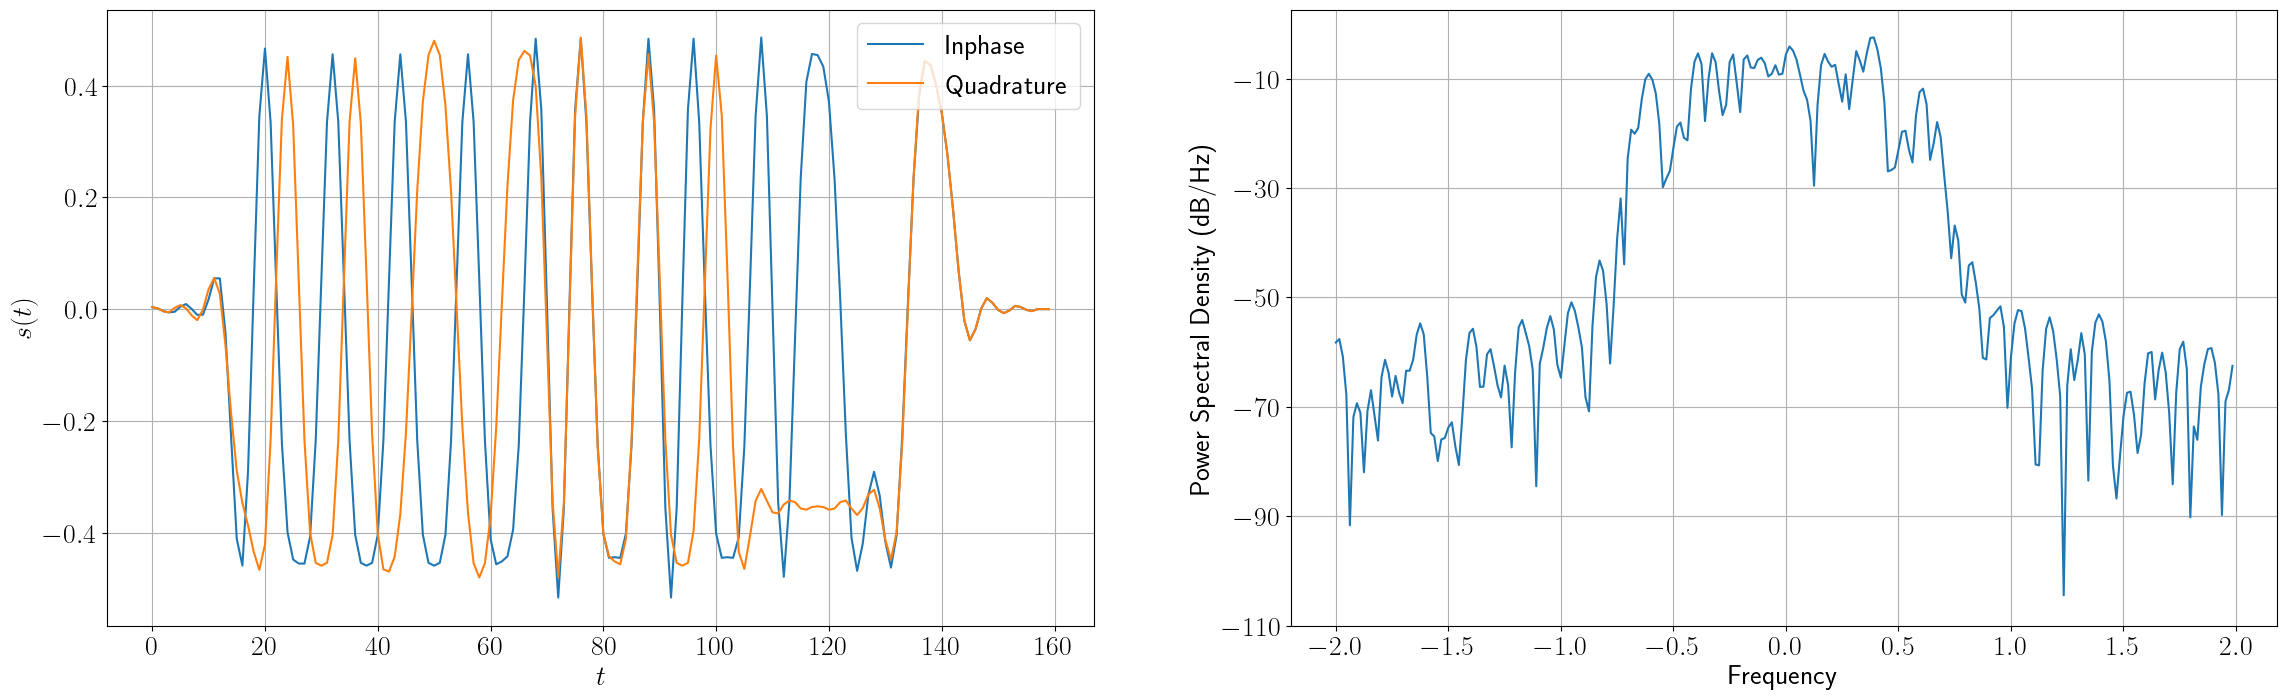

In [6]:
plt.subplot(121)
plt.plot( np.real( s_Tx ), label='Inphase' )
plt.plot( np.imag( s_Tx ), label='Quadrature' )

plt.xlabel('$t$')
plt.ylabel('$s(t)$')
plt.grid(True)
plt.legend( loc='upper right' )

plt.subplot(122)
plt.psd( s_Tx, Fs=1/t_sample);

### Parameters of estimation

In [7]:
# vector for storing variances of estimation
var_delta_phase = np.zeros( len(EsN0_dB) )

# number of trials per simulation point
N_trials_phase = int( 1e3 )


# delta phi max (taken in both directions, i.e. [-delta_phi_max, delta_phi_max])
delta_phi_max = -np.pi/8

### Loop for SNRs and perform simulation

In [8]:
# loop for SNRs
for ind_esn0, esn0 in enumerate(EsN0_dB):

    # determine variance of the noise
    sigma2 = 10**( -esn0/10 )
    
    # initialize error vector
    delta_phase = np.zeros( N_trials_phase )

    # loop for trials with different f_off
    for n in range( N_trials_phase ):
        
        # apply phase offset
        phi_off = np.random.uniform( -delta_phi_max, delta_phi_max )
        
        s_Rx = np.exp( 1j*phi_off ) * s_Tx        
        
        # add noise
        noise = np.sqrt(sigma2/2) * ( np.random.randn(len(s_Rx)) + 1j * np.random.randn(len(s_Rx)) )
        
        # apply noise and insert asynchronity with respect to time
        delta_tau = 0 #np.random.randint( 0, n_up ) 
        r =  s_Rx + noise
        
        # signal after MF
        y_mf = np.convolve( rrc, r )
        
        # down-sampling to symbol time
        y_down = y_mf[ K_filt-1 : K_filt-1 + len(s) * n_sps : n_sps ]
    
        # determine phase estimation according to the approximated ML rule out of [Mengali]
        corr_out = np.sum( np.conjugate( s ) * y_down )
        phi_est = np.angle( corr_out ) 
               
        # determining deviation
        delta_phase[ n ] = phi_est - phi_off 
        
    # find mean and mse of estimation
    var_delta_phase[ ind_esn0 ] = np.var( delta_phase )
    
    
    # show progress
    print('SNR: {}'.format( esn0 ) )

SNR: -15
SNR: -10
SNR: -5
SNR: 0
SNR: 5
SNR: 10
SNR: 15
SNR: 20
SNR: 25
SNR: 30


### Show Results

[]

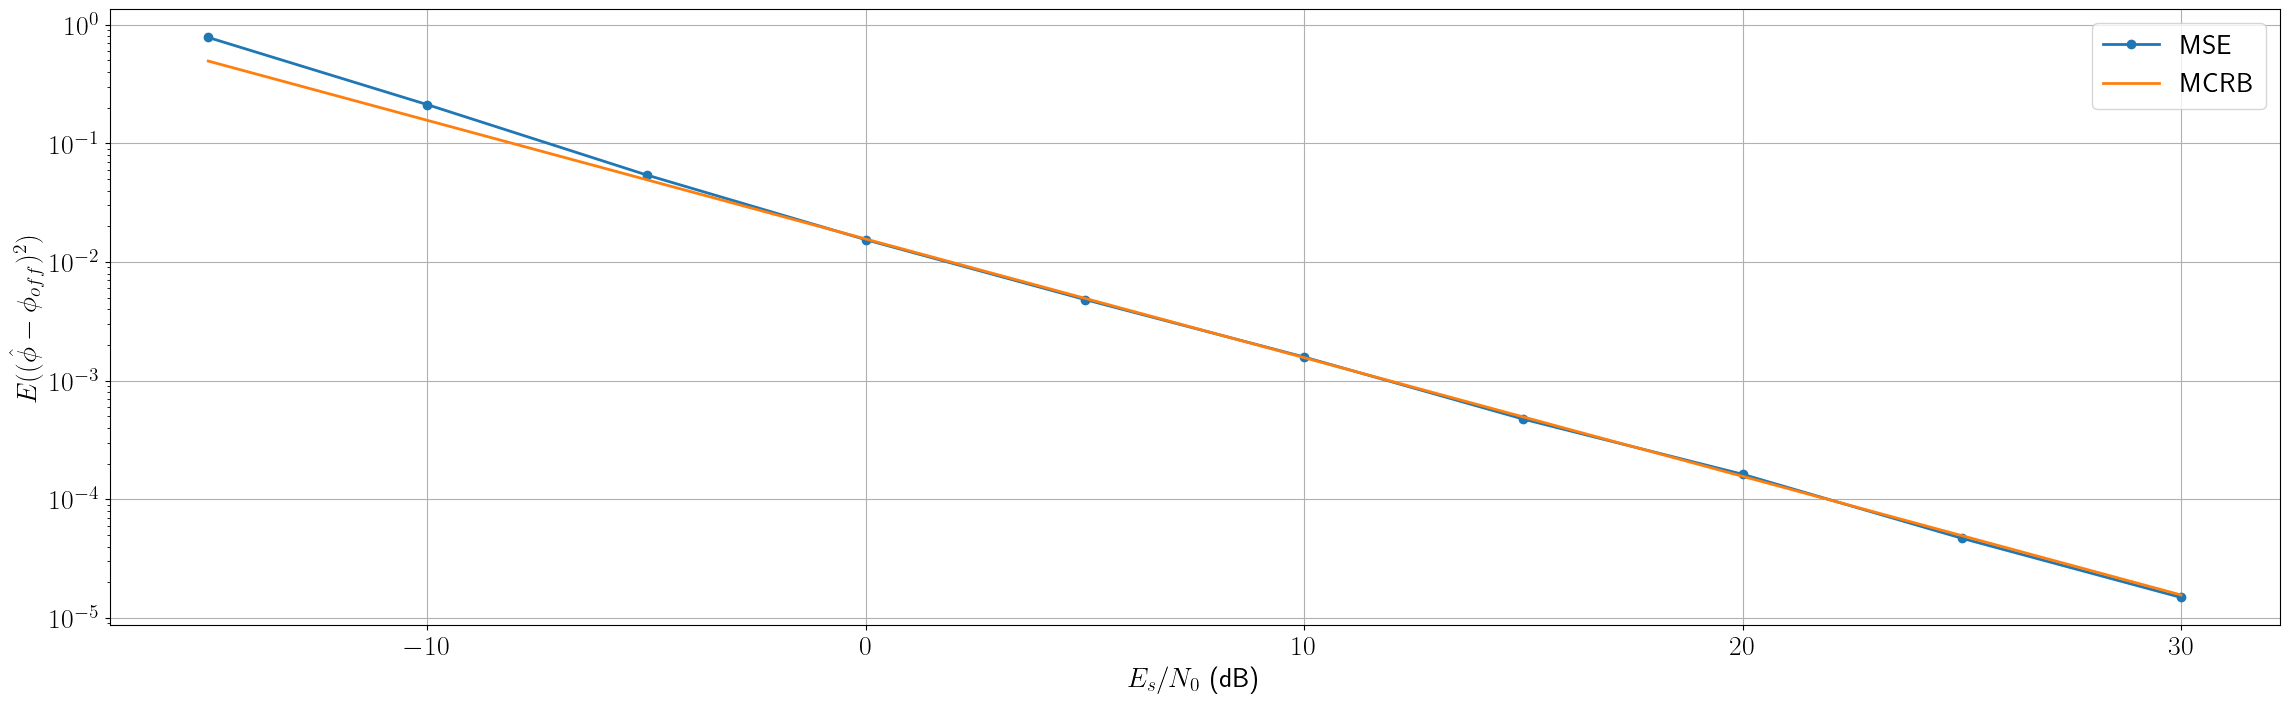

In [9]:
# determine modified Cramer Rao bound according to (5.2.12) in [Mengali]
mcrb = 1 / ( 2 * n_symb * 10**(EsN0_dB/10) )


# plot phase error
plt.figure()
plt.plot( EsN0_dB, var_delta_phase, 'o-', label='MSE', linewidth=2.0 )
plt.plot( EsN0_dB, mcrb,  label='MCRB', linewidth=2.0 )
plt.grid(True)
plt.legend(loc='upper right')
plt.xlabel('$E_s/N_0$ (dB)')
plt.ylabel('$E( (\\hat{\\phi}-\\phi_{off})^2)$')
plt.semilogy()

### Correct phase offset and show symbols

In [10]:
# correct frequency deviation and resample      
y_mf_corrected = y_mf * np.exp( -1j * phi_est )

y_down_corrected = y_mf_corrected[ K_filt-1 : K_filt-1 + len(s) * n_sps : n_sps ]

Text(0, 0.5, 'Re$\\{I_n\\}$')

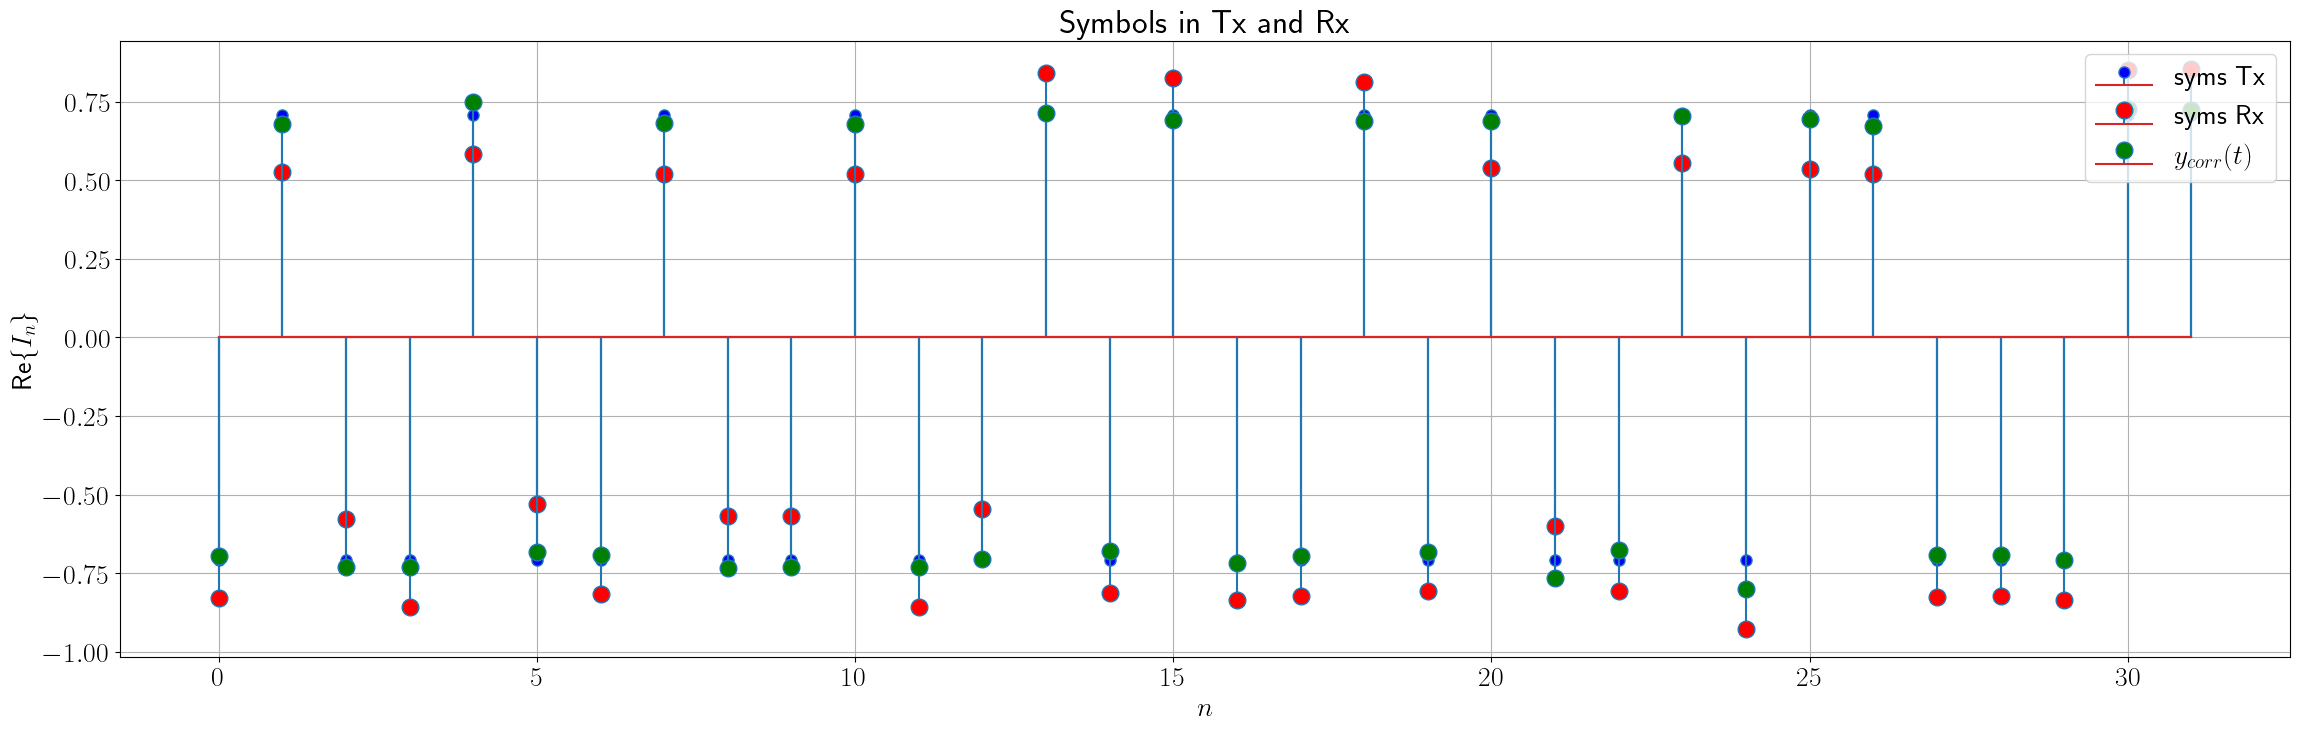

In [11]:
# show symbols
markerline, stemlines, baseline = plt.stem( np.arange(len(s)), np.real(s), label='syms Tx')
plt.setp(markerline, 'markersize', 8, 'markerfacecolor', 'b')

markerline, stemlines, baseline = plt.stem( np.arange(len(y_down)), np.real(y_down), label='syms Rx')
plt.setp(markerline, 'markersize', 12,  'markerfacecolor', 'r',)

markerline, stemlines, baseline = plt.stem( np.arange(len(y_down_corrected)), np.real(y_down_corrected), label='$y_{corr}(t)$')
plt.setp(markerline, 'markersize', 12,  'markerfacecolor', 'g',)

plt.title('Symbols in Tx and Rx')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlabel('$n$')
plt.ylabel('Re$\\{I_n\\}$')